Let's import all the libraries and classes we will need while making this project

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import Regularizer

import tensorflow.keras.utils as ku 
import numpy as np 

# Importing Data

Now we will read the data. I'm reading the data from my github profile link, you can directly use txt files. 

In [2]:
import urllib.request

url = "https://raw.githubusercontent.com/ishantjuyal/Word-Prediction/master/Data/Taylor_Swift.txt"
data = urllib.request.urlopen(url).read().decode("utf-8")

In [ ]:
import re
data = re.sub(r'[^\w\s]', '', data)

Now we will convert data, which is a string to a list containing differrent sentences. 
As we can see, in the string, "end of line" is represented by "\r\n". So, we will split the string by "\r\n" and store them as list in corpus.

In [5]:
# Splitting the string into sentences, while converting whole data into lowercase. 
corpus = data.lower().split("\r\n")

# Now, to make sure no sentence appears twice in our corpus, we use set. Otherwise, it will make the model biased.
#corpus = list(set(corpus))

In [7]:
for i in range(len(corpus)):
    sentence = corpus[i]
    sentence = "startsentence " + sentence + " endsentence"
    corpus[i] = sentence

In [9]:
new_corpus = []

for i in range(0, len(corpus), 3):
    if i+1 in range(len(corpus)):
        sentence = corpus[i] + " newsentence " + corpus[i+1]
        new_corpus.append(sentence)

Let's see how an element of corpus looks like. 

In [10]:
new_corpus[3]

'startsentence but when you think tim mcgraw endsentence newsentence startsentence i hope you think my favorite song endsentence'

In [11]:
corpus[3]

'startsentence i said thats a lie endsentence'

In [12]:
temp = corpus + new_corpus
corpus = []
for i in temp:
    if i not in corpus:
        corpus.append(i)

# Organising Data
Now we will use Tokenizer to convert the words to word vectors. 
Our model understands numbers only, so we need to give it numbers instead of words. 

In [13]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[max(0, i-6):i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [14]:
print("Input Sequences")
print(input_sequences)
print("*****")
print("Shape of Input Sequences", input_sequences.shape)

Input Sequences
[[   0    0    0 ...    0    1 1322]
 [   0    0    0 ...    1 1322    2]
 [   0    0    0 ...    0    1   59]
 ...
 [   6    1 1121 ...    4   72 1122]
 [   1 1121  410 ...   72 1122  674]
 [1121  410    4 ... 1122  674    2]]
*****
Shape of Input Sequences (53180, 7)


In [15]:
print("Predictors")
print(predictors)
print('*****')
print("Shape of predictors is", predictors.shape)

Predictors
[[   0    0    0    0    0    1]
 [   0    0    0    0    1 1322]
 [   0    0    0    0    0    1]
 ...
 [   6    1 1121  410    4   72]
 [   1 1121  410    4   72 1122]
 [1121  410    4   72 1122  674]]
*****
Shape of predictors is (53180, 6)


In [16]:
print("Label")
print(label)
print("*****")
print("Shape of label", label.shape)

Label
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
*****
Shape of label (53180, 2402)


Now, we will start building model using Keras. We use LSTM so that our model could be more accurate and understand the context better. 

In [17]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_len-1))  #(# Embedding Layer)
model.add(Bidirectional(LSTM(150, return_sequences=True)))  #(An LSTM Layer)
model.add(Dropout(0.2))  #(# A dropout layer for regularisation)
model.add(LSTM(100))  #(# Another LSTM Layer)
model.add(Dense(total_words/2, activation='relu'))  #(# A Dense Layer including regularizers)
#(# Last Layer, the shape is equal to total number of words present in our vocabulary)
model.add(Dense(total_words, activation='softmax'))  
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6, 50)             120100    
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 300)            241200    
_________________________________________________________________
dropout (Dropout)            (None, 6, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1201)              121301    
_________________________________________________________________
dense_1 (Dense)              (None, 2402)              2887204   
Total params: 3,530,205
Trainable params: 3,530,205
Non-trainable params: 0
______________________________________________

In [18]:
history = model.fit(predictors, label, epochs= 60, verbose=1)

Epoch 1/60
1662/1662 [==============================] - 15s 9ms/step - loss: 5.0776 - accuracy: 0.1828
Epoch 2/60
1662/1662 [==============================] - 15s 9ms/step - loss: 4.4051 - accuracy: 0.2279
Epoch 3/60
1662/1662 [==============================] - 15s 9ms/step - loss: 3.9224 - accuracy: 0.2645
Epoch 4/60
1662/1662 [==============================] - 15s 9ms/step - loss: 3.4744 - accuracy: 0.3042
Epoch 5/60
1662/1662 [==============================] - 15s 9ms/step - loss: 3.0202 - accuracy: 0.3577
Epoch 6/60
1662/1662 [==============================] - 15s 9ms/step - loss: 2.5858 - accuracy: 0.4200
Epoch 7/60
1662/1662 [==============================] - 15s 9ms/step - loss: 2.2147 - accuracy: 0.4922
Epoch 8/60
1662/1662 [==============================] - 15s 9ms/step - loss: 1.9264 - accuracy: 0.5468
Epoch 9/60
1662/1662 [==============================] - 15s 9ms/step - loss: 1.6996 - accuracy: 0.5974
Epoch 10/60
1662/1662 [==============================] - 15s 9ms/step - l

Now, we will see how our model performed with each iteration. 

In [19]:
import matplotlib.pyplot as plt

def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

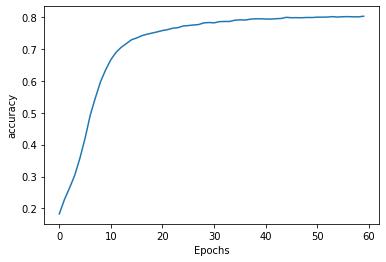

In [20]:
plot_graph(history,'accuracy')

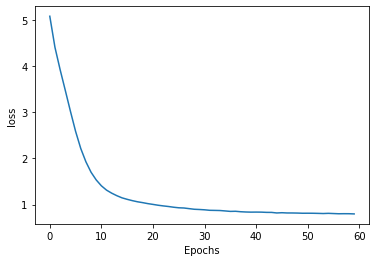

In [21]:
plot_graph(history,'loss')

In [33]:
# Further training if not satisfied
history = model.fit(predictors, label, epochs= 20, verbose=1)

Epoch 1/20
1662/1662 [==============================] - 14s 9ms/step - loss: 0.7980 - accuracy: 0.8027
Epoch 2/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7975 - accuracy: 0.8019
Epoch 3/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.8008 - accuracy: 0.8007
Epoch 4/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7935 - accuracy: 0.8025
Epoch 5/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7922 - accuracy: 0.8028
Epoch 6/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7928 - accuracy: 0.8021
Epoch 7/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7930 - accuracy: 0.8024
Epoch 8/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7900 - accuracy: 0.8032
Epoch 9/20
1662/1662 [==============================] - 15s 9ms/step - loss: 0.7880 - accuracy: 0.8030
Epoch 10/20
1662/1662 [==============================] - 15s 9ms/step - l

In [ ]:
# How to save your trained model

# serialize to JSON
json_file = model.to_json()
with open("model.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights("model.h5")

In [ ]:
# How to load your saved model

from keras.models import model_from_json

# load json and create model
file = open('model.json', 'r')
model_json = file.read()
file.close()
loaded_model = model_from_json(model_json)
# load weights
loaded_model.load_weights("model.h5")

# Generate Lyrics

In [34]:
def get_lyrics(seed_text):
    ans = True
    end_count = 0
    seed_text = "startsentence " + seed_text 
    while True:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis = -1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        if output_word == "endsentence":
            end_count += 1

        if end_count == 3:
            new_sentence_words = seed_text.split()[1:]
            seed_text = ' '.join(new_sentence_words)
            return(seed_text)
            ans = False
            break
        seed_text += " " + output_word
    if ans == True:
        new_sentence_words = seed_text.split()[1:]
        seed_text = ' '.join(new_sentence_words)
        return(seed_text)


def make_lyrics(text):
    seed_text = get_lyrics(text)
    lyrics = seed_text.split("newsentence")
    for i in range(len(lyrics)):
        sentence = lyrics[i]
        words = sentence.split()
        if "endsentence" in words:
            words.remove("endsentence")
        if "startsentence" in words:
            words.remove("startsentence")
        sentence = ' '.join(words)
        lyrics[i] = sentence
    for sentence in lyrics:
        print(sentence)

In [35]:
make_lyrics("How")

How you said youd be here
and it was like slow motion
got me feeling like im nothing


In [36]:
make_lyrics("When I will")

When I will hold on to you
and time can heal but this wont
my old scarf from that very first week


In [37]:
make_lyrics("Light in the")

Light in the night forever ships
oh yeah
and i dont know what to say since a twist of fate when it all broke down


In [38]:
make_lyrics("Walking")

Walking through a crowd the village is aglow
kaleidoscope of loud heartbeats under coats
or if i strike out of you


In [39]:
make_lyrics("Do you")

Do you believe it
two headlights shine through the sleepless night
and i know that you see what youre doing to me


In [43]:
make_lyrics("If this is")

If this is just gonna shake shake shake shake shake
i shake it off i shake it off
i never miss a beat
